In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
import gc
from pathlib import Path

from os.path import join, isfile
from os import path, scandir, listdir

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import softmax

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
#import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.DataFrame(pd.read_csv(INPUT / "train.csv")[target])
#test = pd.read_csv(INPUT / "test.csv")
test = pd.DataFrame()
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
def list_all_files(location='../input/tps-oct-lv0', pattern=None, recursive=True):
    """
    This function returns a list of files at a given location (including subfolders)
    
    - location: path to the directory to be searched
    - pattern: part of the file name to be searched (ex. pattern='.csv' would return all the csv files)
    - recursive: boolean, if True the function calls itself for every subdirectory it finds
    """
    subdirectories= [f.path for f in scandir(location) if f.is_dir()]
    files = [join(location, f) for f in listdir(location) if isfile(join(location, f))]
    if recursive:
        for directory in subdirectories:
            files.extend(list_all_files(directory))
    if pattern:
        files = [f for f in files if pattern in f]
    return files

In [6]:
names = ['bizen', 'henke', 'hamza', '28smiles','kashif', 'kosta', 'kaveh', 'dlaststark', 'pca', 'xgb2']

In [7]:
namesec = ['lonnie', 'hgb', 'xgb_d2s', 'ctb_d2s']

In [8]:
pred = list_all_files(pattern='oof')

for i in range(len(names)):
    cnt=1
    for file in pred:
        if names[i] in file.split('/')[3]:
            train[names[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
pred = list_all_files(location='../input/tps-oct-lv0-sec', pattern='oof')

for i in range(len(namesec)):
    cnt=1
    for file in pred:
        if namesec[i] in file.split('/')[3]:
            train[namesec[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
train.columns

Index(['target', 'bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1',
       'henke2', 'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3',
       'hamza4', 'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5'],
      dtype='object')

In [9]:
pred = list_all_files(pattern='pred')

for i in range(len(names)):
    cnt=1
    for file in pred:
        if names[i] in file.split('/')[3]:
            test[names[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
pred = list_all_files(location='../input/tps-oct-lv0-sec', pattern='pred')

for i in range(len(namesec)):
    cnt=1
    for file in pred:
        if namesec[i] in file.split('/')[3]:
            test[namesec[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
test.columns

Index(['bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1', 'henke2',
       'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3', 'hamza4',
       'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5'],
      dtype='object')

In [10]:
for i in range(5):

    train['lgb'+str(i+1)] = np.load("../input/tps-oct-lv0/"+str(i+2017)+"lgb_oof.npy")
    test['lgb'+str(i+1)] = np.load("../input/tps-oct-lv0/"+str(i+2017)+"lgb_pred.npy")
    
    train['xgb'+str(i+1)] = np.load("../input/tps-oct-lv0/agg"+str(i+1)+"_xgb_oof.npy")
    test['xgb'+str(i+1)] = np.load("../input/tps-oct-lv0/agg"+str(i+1)+"_xgb_pred.npy")

In [11]:
#lv1

nameslv1 = ['ridge', 'gnb', 'lgb', 'xgb', 'rf', 'nn']

pred = list_all_files(location='../input/tps-oct-lv1', pattern='oof')


for i in range(len(nameslv1)):
    cnt=1
    for file in pred:
        if nameslv1[i] in file.split('/')[3]:
            train[nameslv1[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
train.columns

Index(['target', 'bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1',
       'henke2', 'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3',
       'hamza4', 'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5',
       'lgb1', 'xgb1', 'lgb2', 'xgb2', 'lgb3', 'xgb3', 'lgb4', 'xgb4', 'lgb5',
       'xgb5', 'ridge1', 'gnb1', 'rf1'],
      dtype='object')

In [12]:
pred = list_all_files(location='../input/tps-oct-lv1', pattern='pred')

for i in range(len(nameslv1)):
    cnt=1
    for file in pred:
        if nameslv1[i] in file.split('/')[3]:
            test[nameslv1[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
test.columns

Index(['bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1', 'henke2',
       'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3', 'hamza4',
       'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5',
       'lgb1', 'xgb1', 'lgb2', 'xgb2', 'lgb3', 'xgb3', 'lgb4', 'xgb4', 'lgb5',
       'xgb5', 'ridge1', 'gnb1', 'rf1'],
      dtype='object')

In [13]:
train

,target,bizen1,bizen2,bizen3,bizen4,bizen5,henke1,henke2,henke3,henke4,...,xgb2,lgb3,xgb3,lgb4,xgb4,lgb5,xgb5,ridge1,gnb1,rf1
0,1,0.685970,0.662352,0.683341,0.680801,0.662460,0.678655,0.656029,0.680616,0.649345,...,0.671891,0.666535,0.685974,0.661209,0.675093,0.664779,0.669547,0.662315,9.999887e-01,0.627828
1,1,0.164244,0.175831,0.182369,0.179480,0.184402,0.173803,0.186263,0.179768,0.198704,...,0.179524,0.195837,0.168033,0.186122,0.176252,0.173731,0.173688,0.219062,2.156250e-09,0.234431
2,1,0.844541,0.846079,0.858312,0.857051,0.853688,0.866199,0.867833,0.866303,0.864103,...,0.850739,0.843738,0.857366,0.850835,0.839731,0.849409,0.834846,0.806280,1.000000e+00,0.789477
3,1,0.531215,0.519297,0.512399,0.528917,0.522211,0.522347,0.517418,0.516195,0.519794,...,0.491057,0.510195,0.517595,0.512810,0.530310,0.500083,0.510080,0.515744,5.438057e-01,0.504650
4,1,0.831099,0.825800,0.823048,0.842095,0.831419,0.822539,0.819840,0.831176,0.824627,...,0.828377,0.838210,0.833570,0.835198,0.837250,0.830752,0.825002,0.788321,1.000000e+00,0.769031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.749454,0.728286,0.750493,0.756895,0.729964,0.748238,0.732079,0.747450,0.740191,...,0.785713,0.736283,0.765217,0.744252,0.777756,0.756547,0.770561,0.731854,1.000000e+00,0.704250
999996,0,0.113403,0.108968,0.110669,0.110366,0.113412,0.113715,0.110792,0.121641,0.113594,...,0.124537,0.125966,0.126810,0.134536,0.119897,0.123562,0.133121,0.177373,6.961185e-11,0.172403
999997,0,0.175456,0.192199,0.180284,0.173818,0.175606,0.189084,0.189191,0.174671,0.179136,...,0.166049,0.175500,0.165913,0.162536,0.165403,0.168275,0.168423,0.216083,1.307080e-09,0.229616
999998,1,0.929157,0.924142,0.926665,0.930489,0.925823,0.927134,0.924868,0.934043,0.931205,...,0.906044,0.900127,0.901903,0.905297,0.906325,0.908480,0.905384,0.842177,1.000000e+00,0.851114


In [14]:
test

,bizen1,bizen2,bizen3,bizen4,bizen5,henke1,henke2,henke3,henke4,henke5,...,xgb2,lgb3,xgb3,lgb4,xgb4,lgb5,xgb5,ridge1,gnb1,rf1
0,0.724021,0.728361,0.725621,0.732192,0.732434,0.721390,0.714076,0.725906,0.724935,0.726242,...,0.748552,0.743572,0.751432,0.729459,0.749871,0.740535,0.741732,0.715178,9.999999e-01,0.684605
1,0.240544,0.251751,0.238587,0.244314,0.244071,0.245993,0.248753,0.239175,0.249142,0.245428,...,0.231134,0.233782,0.234014,0.229059,0.234173,0.234675,0.232551,0.261043,5.476935e-08,0.285162
2,0.913782,0.913643,0.910910,0.913908,0.913073,0.915849,0.913297,0.910373,0.912450,0.910781,...,0.903727,0.906030,0.902198,0.904603,0.901317,0.903600,0.900759,0.837972,1.000000e+00,0.851214
3,0.836404,0.837768,0.831884,0.834451,0.839407,0.837518,0.827153,0.831223,0.835070,0.830312,...,0.856662,0.852321,0.852952,0.844508,0.854423,0.852309,0.851234,0.794506,1.000000e+00,0.780640
4,0.267384,0.267531,0.274970,0.272950,0.266764,0.277864,0.276774,0.277562,0.278863,0.269478,...,0.270479,0.256417,0.261957,0.256586,0.257069,0.253683,0.258448,0.281062,2.060277e-07,0.307866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.976007,0.975220,0.975621,0.975229,0.975181,0.975425,0.975555,0.975485,0.974509,0.975618,...,0.967489,0.965199,0.966779,0.965412,0.965603,0.965045,0.965611,0.868528,1.000000e+00,0.878929
499996,0.840347,0.838480,0.840176,0.839729,0.838066,0.844565,0.839685,0.841652,0.841801,0.841009,...,0.831930,0.832500,0.831930,0.829926,0.831986,0.832744,0.830885,0.793974,1.000000e+00,0.773193
499997,0.291822,0.298287,0.295252,0.294883,0.287416,0.282703,0.294662,0.283416,0.288363,0.284486,...,0.285845,0.287821,0.287705,0.289969,0.290894,0.291508,0.293653,0.303442,1.024979e-06,0.323833
499998,0.515441,0.512511,0.520871,0.509493,0.509964,0.512141,0.509483,0.509124,0.504425,0.493857,...,0.509809,0.506968,0.499887,0.503565,0.512421,0.501782,0.497552,0.512764,4.700489e-01,0.501026


# Preprocessing

In [15]:
features = test.columns
#features = [col for col in train.columns if 'pred' in col]

In [16]:
ss = StandardScaler()

In [17]:
test[features]

,bizen1,bizen2,bizen3,bizen4,bizen5,henke1,henke2,henke3,henke4,henke5,...,xgb2,lgb3,xgb3,lgb4,xgb4,lgb5,xgb5,ridge1,gnb1,rf1
0,0.724021,0.728361,0.725621,0.732192,0.732434,0.721390,0.714076,0.725906,0.724935,0.726242,...,0.748552,0.743572,0.751432,0.729459,0.749871,0.740535,0.741732,0.715178,9.999999e-01,0.684605
1,0.240544,0.251751,0.238587,0.244314,0.244071,0.245993,0.248753,0.239175,0.249142,0.245428,...,0.231134,0.233782,0.234014,0.229059,0.234173,0.234675,0.232551,0.261043,5.476935e-08,0.285162
2,0.913782,0.913643,0.910910,0.913908,0.913073,0.915849,0.913297,0.910373,0.912450,0.910781,...,0.903727,0.906030,0.902198,0.904603,0.901317,0.903600,0.900759,0.837972,1.000000e+00,0.851214
3,0.836404,0.837768,0.831884,0.834451,0.839407,0.837518,0.827153,0.831223,0.835070,0.830312,...,0.856662,0.852321,0.852952,0.844508,0.854423,0.852309,0.851234,0.794506,1.000000e+00,0.780640
4,0.267384,0.267531,0.274970,0.272950,0.266764,0.277864,0.276774,0.277562,0.278863,0.269478,...,0.270479,0.256417,0.261957,0.256586,0.257069,0.253683,0.258448,0.281062,2.060277e-07,0.307866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.976007,0.975220,0.975621,0.975229,0.975181,0.975425,0.975555,0.975485,0.974509,0.975618,...,0.967489,0.965199,0.966779,0.965412,0.965603,0.965045,0.965611,0.868528,1.000000e+00,0.878929
499996,0.840347,0.838480,0.840176,0.839729,0.838066,0.844565,0.839685,0.841652,0.841801,0.841009,...,0.831930,0.832500,0.831930,0.829926,0.831986,0.832744,0.830885,0.793974,1.000000e+00,0.773193
499997,0.291822,0.298287,0.295252,0.294883,0.287416,0.282703,0.294662,0.283416,0.288363,0.284486,...,0.285845,0.287821,0.287705,0.289969,0.290894,0.291508,0.293653,0.303442,1.024979e-06,0.323833
499998,0.515441,0.512511,0.520871,0.509493,0.509964,0.512141,0.509483,0.509124,0.504425,0.493857,...,0.509809,0.506968,0.499887,0.503565,0.512421,0.501782,0.497552,0.512764,4.700489e-01,0.501026


In [18]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int64

In [19]:
del names
del pred

gc.collect()

120

# Logistic

In [20]:
logistic_params = {
               'penalty':'elasticnet',
                  'max_iter':N_ESTIMATORS,
                   'tol':1e-8,
                  'n_jobs':-1,
                  'solver':'saga',
        
             
   'C': 0.00020525981894354387, 
    'l1_ratio': 0.9744402752066574
}

In [21]:
logistic_oof = np.zeros(train.shape[0])
logistic_pred = np.zeros(test.shape[0])
#logistic_importances = pd.DataFrame()

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=range(SEED, SEED+20)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]
        
    X_train[features] = ss.fit_transform(X_train[features])
    X_valid[features] = ss.transform(X_valid[features])
    X_test[features] = ss.transform(X_test[features])

    start = time.time()
    for inseed in seed_list:
        logistic_params['random_state'] = inseed

        model = LogisticRegression(**logistic_params)
        model.fit(
            X_train, 
            y_train,
            
        )

        #with open(f"logistic_model{fold}_seed{inseed}.pkl", 'wb') as f:
        #   pickle.dump(model, f)


        logistic_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        logistic_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)

    del X_train
    del y_train
    del X_valid
    del X_test
    del model
    gc.collect()
        
    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, logistic_oof[val_idx])
    print(f"fold {fold} - logistic auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

logistic_pred /= N_SPLITS
print(f"oof logistic_auc = {roc_auc_score(train[target], logistic_oof)}")

np.save("logistic_oof.npy", logistic_oof)
np.save("logistic_pred.npy", logistic_pred)

===== fold 0 =====
fold 0 - logistic auc: 0.856668, elapsed time: 926.05sec

===== fold 1 =====
fold 1 - logistic auc: 0.857968, elapsed time: 944.75sec

===== fold 2 =====
fold 2 - logistic auc: 0.858521, elapsed time: 964.73sec

===== fold 3 =====
fold 3 - logistic auc: 0.856990, elapsed time: 977.02sec

===== fold 4 =====
fold 4 - logistic auc: 0.856864, elapsed time: 940.01sec

oof logistic_auc = 0.8573846632092297


# OOF predictions

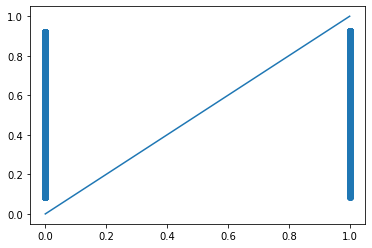

In [22]:
plt.plot(train[target], train[target])
plt.scatter(train[target], logistic_oof)

In [23]:
del logistic_oof

gc.collect()

20

# Submission

In [24]:
submission[target] = logistic_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.760055
1,1000001,0.225241
2,1000002,0.902551
3,1000003,0.855436
4,1000004,0.252764
...,...,...
499995,1499995,0.920515
499996,1499996,0.850709
499997,1499997,0.271134
499998,1499998,0.518064


# Log

/////// lv1 average /////////
ver3

//// lv0+lv1 raw ////
ver4